In [1]:
import spacy
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Embedding

In [3]:
nlp = spacy.load('en_core_web_lg')

In [4]:
nlp.vocab["king"].similarity(nlp.vocab["queen"])

0.610884428024292

In [5]:
king_vec = nlp.vocab["king"].vector
queen_vec = nlp.vocab["queen"].vector
man_vec = nlp.vocab["man"].vector
woman_vec = nlp.vocab["women"].vector

<Axes: >

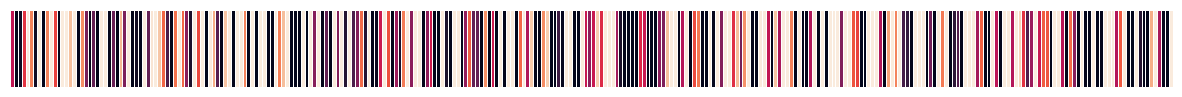

In [6]:
plt.figure(figsize=(15,1))
sns.heatmap([king_vec], xticklabels=False, yticklabels=False, cbar=False,
            vmin=-2, vmax=2, linewidths=0.7)
# plt.show()

<Axes: >

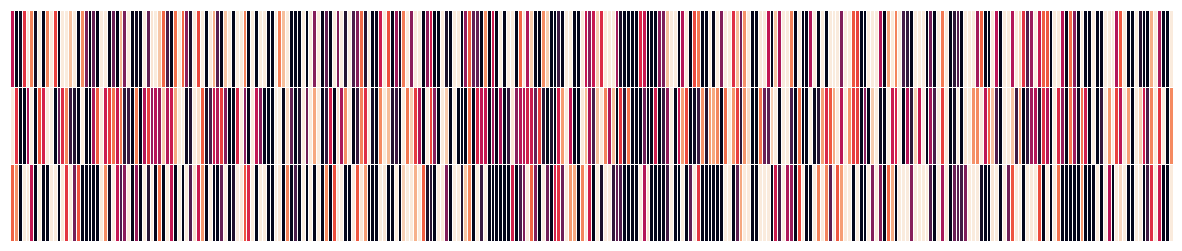

In [7]:
plt.figure(figsize=(15,3))
sns.heatmap([king_vec, queen_vec, king_vec-man_vec+woman_vec], xticklabels=False, yticklabels=False, cbar=False,
            vmin=-2, vmax=2, linewidths=0.7)

# Classification

In [27]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

In [10]:
dataset = fetch_20newsgroups(data_home="./data", subset="all")

In [11]:
X, y = dataset.data, dataset.target

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
for token in  nlp("Apple is looking at buying U.K. startup for $1 billion"):
  print('Word: {}  --> {}'.format(token.text, token.lemma_))

Word: Apple  --> Apple
Word: is  --> be
Word: looking  --> look
Word: at  --> at
Word: buying  --> buy
Word: U.K.  --> U.K.
Word: startup  --> startup
Word: for  --> for
Word: $  --> $
Word: 1  --> 1
Word: billion  --> billion


In [19]:
def get_text_vectors(docs):
    vectors = []
    for doc in nlp.pipe(docs, batch_size=500):
        vectors.append(doc.vector)
    return np.array(vectors)

In [20]:
X_train_vec = get_text_vectors(X_train)
X_test_vec = get_text_vectors(X_test)

In [29]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train_vec, y_train)

y_pred = model.predict(X_test_vec)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.746684350132626


In [46]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split

X_train_tensor = torch.tensor(X_train_vec, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_vec, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# 创建数据集和数据加载器
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# 划分训练集和验证集
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# 定义模型
class TextClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers=2):
        super(TextClassifier, self).__init__()
        self.n_layers = n_layers
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers=n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)


    def forward(self, x):
        x = x.unsqueeze(1)  # 增加一维，作为序列长度
        h0 = torch.zeros(self.n_layers, x.size(0), hidden_dim).to(x.device)  # 初始隐藏状态
        out, _ = self.gru(x, h0)  # GRU 输出
        out = self.fc(out[:, -1, :])  # 全连接层 只取最后一个时间步的输出
        return out


# 初始化模型、损失函数和优化器
input_dim = X_train_vec.shape[1]
hidden_dim = 128
output_dim = 20  # 20 个类别
model = TextClassifier(input_dim, hidden_dim, output_dim)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# 训练模型
num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

    # 验证模型
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    print(f'Validation Loss: {val_loss/len(val_loader):.4f}')


# 评估模型
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f'Test Accuracy: {accuracy:.4f}')

Epoch [1/100], Loss: 2.9599
Validation Loss: 2.9083
Epoch [2/100], Loss: 2.8030
Validation Loss: 2.6843
Epoch [3/100], Loss: 2.5273
Validation Loss: 2.4019
Epoch [4/100], Loss: 2.2756
Validation Loss: 2.1943
Epoch [5/100], Loss: 2.1018
Validation Loss: 2.0414
Epoch [6/100], Loss: 1.9655
Validation Loss: 1.9269
Epoch [7/100], Loss: 1.8588
Validation Loss: 1.8349
Epoch [8/100], Loss: 1.7664
Validation Loss: 1.7564
Epoch [9/100], Loss: 1.6890
Validation Loss: 1.6862
Epoch [10/100], Loss: 1.6216
Validation Loss: 1.6305
Epoch [11/100], Loss: 1.5645
Validation Loss: 1.5811
Epoch [12/100], Loss: 1.5150
Validation Loss: 1.5372
Epoch [13/100], Loss: 1.4666
Validation Loss: 1.4999
Epoch [14/100], Loss: 1.4313
Validation Loss: 1.4683
Epoch [15/100], Loss: 1.3952
Validation Loss: 1.4368
Epoch [16/100], Loss: 1.3599
Validation Loss: 1.4088
Epoch [17/100], Loss: 1.3307
Validation Loss: 1.3797
Epoch [18/100], Loss: 1.3014
Validation Loss: 1.3565
Epoch [19/100], Loss: 1.2799
Validation Loss: 1.3370
Ep